# **Homework 1 - ML for Time Series**

### Authors:
- Naïl Khelifa
- Tom Rossa

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from statsmodels.tsa.stattools import acf # for the sample autocorrelation function 
from scipy.signal import periodogram 
from sklearn.linear_model import Lasso

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 1 (vérification)

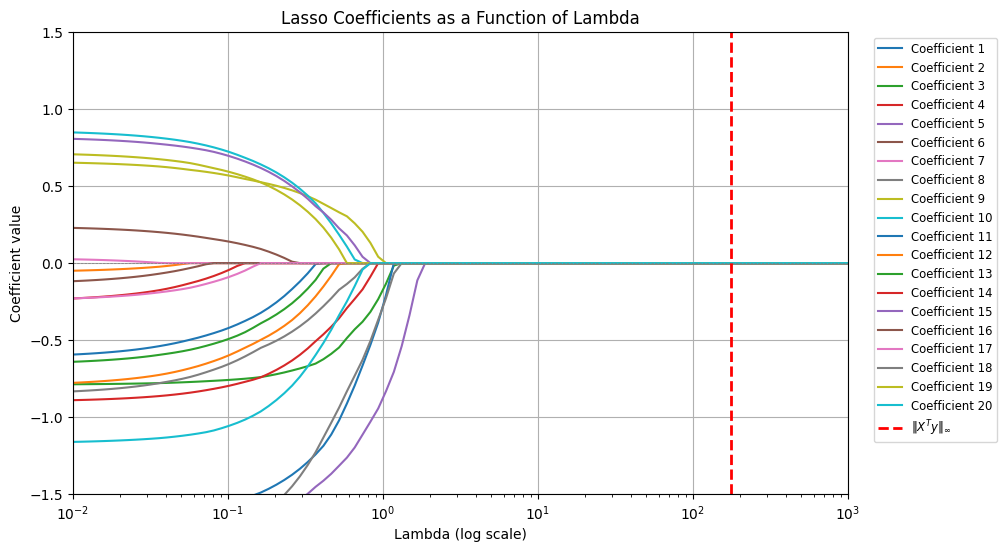

Value of lambda corresponding to ||X^Ty||_∞: 177.3666


In [9]:
# Generate synthetic data
np.random.seed(42)  # For reproducibility
n, p = 100, 20  # Number of samples (n) and features (p)
X = np.random.randn(n, p)
true_beta = np.random.randn(p)
y = X @ true_beta + np.random.randn(n) * 0.5  # y = X*beta + noise

# Calculate the infinity norm of X^T y
X_transpose_y = X.T @ y
lambda_inf = np.max(np.abs(X_transpose_y))

# Varying lambda
lambdas = np.logspace(-2, 3, 100)  # Range of lambda values
coefs = []

# Fit Lasso for different values of lambda
for l in lambdas:
    model = Lasso(alpha=l)
    model.fit(X, y)
    coefs.append(model.coef_)

# Convert to array for easier indexing
coefs = np.array(coefs)

# Plotting the coefficients as a function of lambda
plt.figure(figsize=(10, 6))
for i in range(p):
    plt.plot(lambdas, coefs[:, i], label=f'Coefficient {i + 1}')

plt.xscale('log')
plt.axhline(0, color='gray', lw=0.5, ls='--')
plt.axvline(lambda_inf, color='red', linestyle='--', label=r'$\|X^Ty\|_{\infty}$', linewidth=2)
plt.title('Lasso Coefficients as a Function of Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient value')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')
plt.grid()
plt.ylim(-1.5, 1.5)
plt.xlim(0.01, 1000)  # Set x-axis limits to include the lambda_inf line
plt.show()

# Print the value of lambda_inf
print(f'Value of lambda corresponding to ||X^Ty||_∞: {lambda_inf:.4f}')

## Question 6

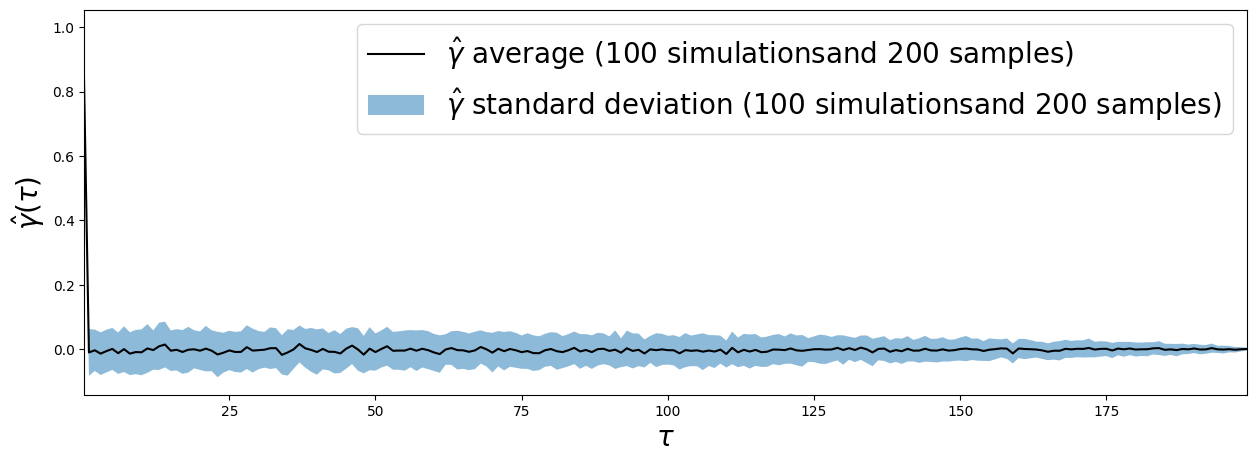

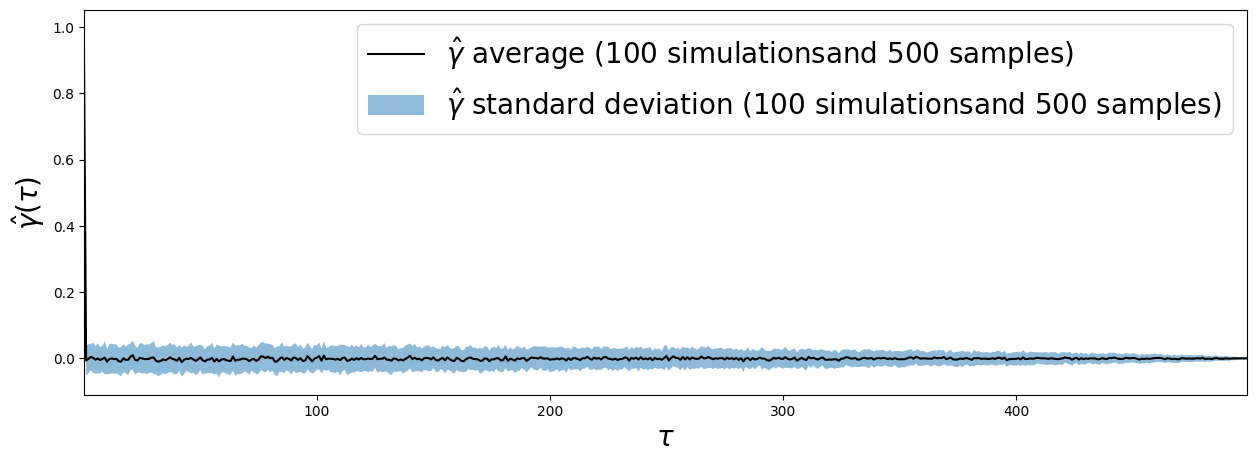

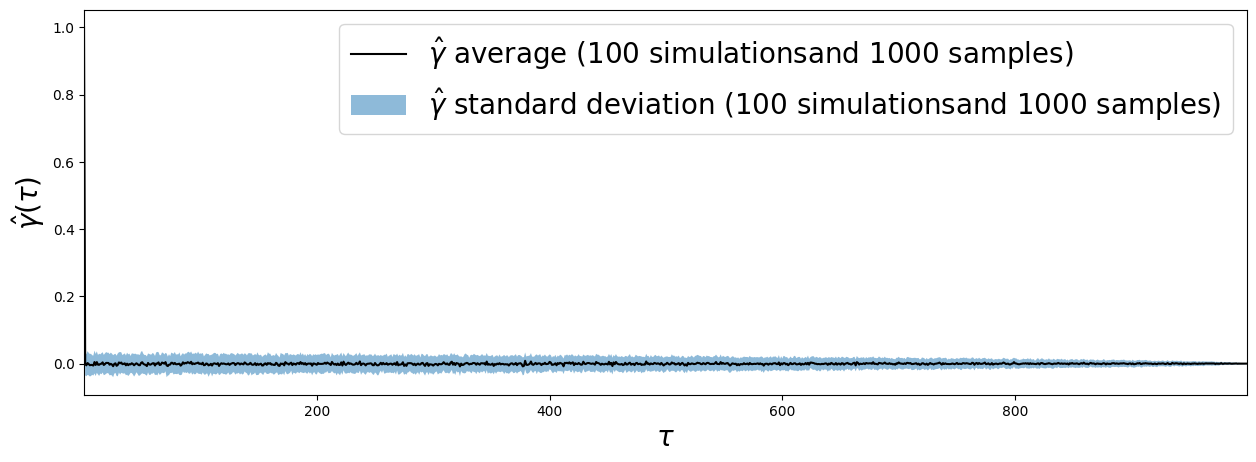

In [55]:
#  freqs = np.linspace(0, 0.5, N_samples) # since f_s = 1 Hz
N_trials = 100

for N_samples in [200, 500, 1000]:
    autocorr = []
    for _ in range(N_trials): # repeat this operation on the number of trials
        signal = np.random.randn(N_samples) # one realization of X_1, ..., X_N_samples (WGN)
        autocorr.append(acf(signal, nlags=N_samples, fft=True)) 

    autocorr = np.array(autocorr)

    y = np.arange(N_samples)
    
    fig, ax = fig_ax()
    
    avg = autocorr.mean(axis=0)
    std = autocorr.std(axis=0)
    
    ax.plot(y, avg, 'k-', label=r'$\hat{\gamma}$ average (100 simulations'+ f'and {N_samples} samples)')
    ax.fill_between(y, avg - std, avg + std, alpha=0.5, label=r'$\hat{\gamma}$ standard deviation (100 simulations'+ f'and {N_samples} samples)')
    
    # Ajouter un titre
    # ax.set_title(f'Sample autocorrelation ({N_samples} samples and {100} simulations)')
    ax.set_xlim(left=0.2)  # Décale le début de l'axe des abscisses à 0.1
    # Ajouter des légendes
    ax.legend(fontsize=20)
    
    # Titres des axes
    ax.set_xlabel(r'$\tau$', fontsize=20)
    ax.set_ylabel(r'$\hat{\gamma}(\tau)$', fontsize=20)

    plt.show()

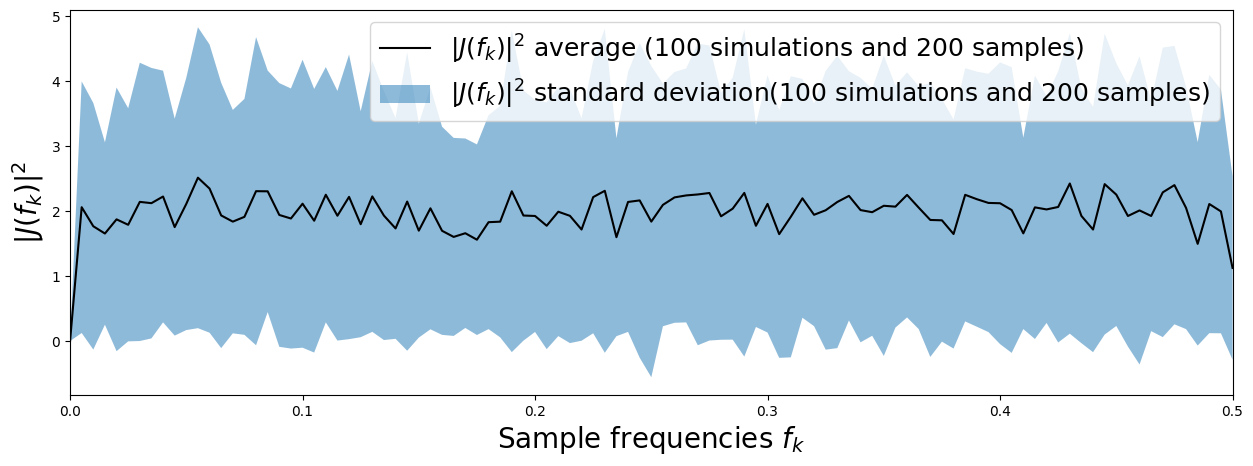

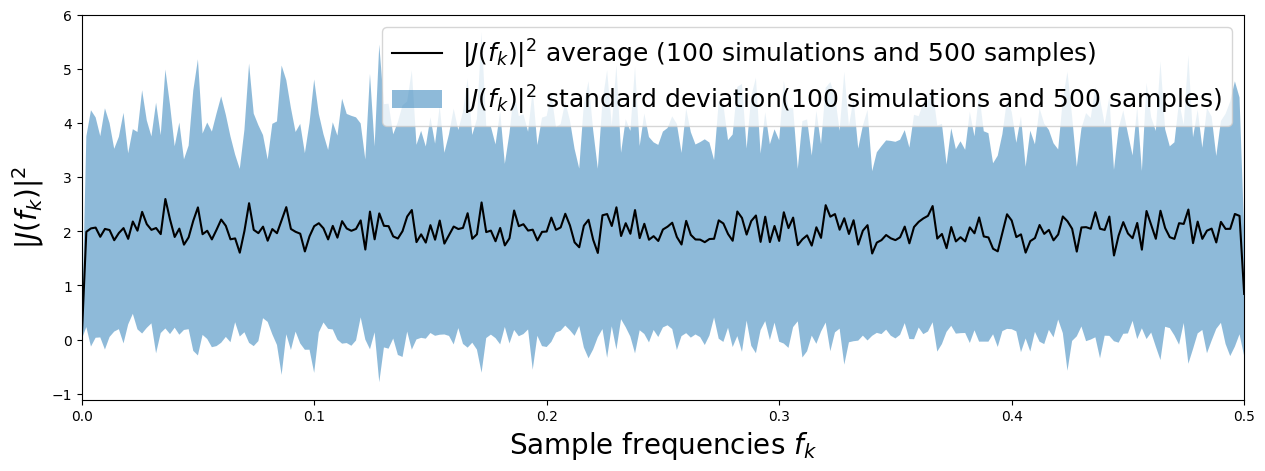

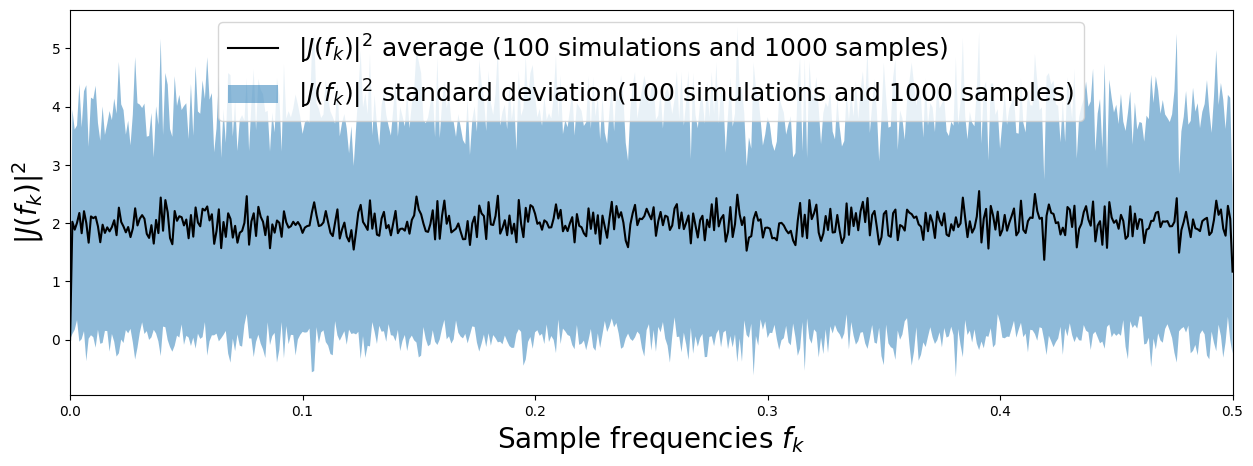

In [47]:
#  freqs = np.linspace(0, 0.5, N_samples) # since f_s = 1 Hz
N_trials = 100
F_s = 1 # Hz 

for N_samples in [200, 500, 1000]:
    periodogram_arr = []
    sample_frequencies = []
    for _ in range(N_trials): # repeat this operation on the number of trials
        signal = np.random.randn(N_samples) # one realization of X_1, ..., X_N_samples (WGN)
        f, Pxx = periodogram(signal, fs=1)
        periodogram_arr.append(Pxx)
        sample_frequencies.append(f)

    sample_frequencies = np.array(sample_frequencies)
    periodogram_arr = np.array(periodogram_arr)

    fig, ax = fig_ax()
    
    avg = periodogram_arr.mean(axis=0)
    std = periodogram_arr.std(axis=0)

    ax.plot(sample_frequencies[0], avg, 'k-', label=rf'$|J(f_k)|^2$ average (100 simulations and {N_samples} samples)')
    ax.fill_between(sample_frequencies[0], avg - std, avg + std, alpha=0.5, label=rf'$|J(f_k)|^2$ standard deviation(100 simulations and {N_samples} samples)')
    
    # Ajouter un titre
    # ax.set_title(f'Periodogram ({N_samples} samples and {100} simulations)')
    
    # Ajouter des légendes
    ax.legend(fontsize=18)
    
    # Titres des axes
    ax.set_xlabel(r'Sample frequencies $f_k$', fontsize=20)
    ax.set_ylabel(r'$|J(f_k)|^2$', fontsize=20)

    plt.show()

## Question 9

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

## Question 11